<a href="https://colab.research.google.com/github/jinxianyap/classification-models/blob/master/metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install --upgrade gspread

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/WISE AI/Classification

from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

Requirement already up-to-date: gspread in /usr/local/lib/python3.6/dist-packages (3.6.0)
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/WISE AI/Classification


In [22]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import json
import operator
import matplotlib.image as mpimg

In [23]:
def load_model_metrics(sheet_name):
  worksheet = gc.open('results').worksheet(sheet_name)
  model = {
      'name': sheet_name,
      'train_imgs': [],
      'test_imgs': []
  }
  classes = []
  i = 2

  while len(worksheet.row_values(i)) > 0:
    row = worksheet.row_values(i)
    if not ('activation' in model):
      model['activation'] = row[1]
    if not ('pretrained' in model):
      model['pretrained'] = row[2]

    qry = 'train_imgs' if row[3] == 'train' else 'test_imgs'
    ls = model[qry]
    ls.append({'image_path': row[5], 'ground_truth': row[6], 'prediction': row[7]})
    if not (row[6] in classes):
      classes.append(row[6])
    model[qry] = ls
    i += 1

  return model, classes

In [24]:
def display_error_samples(samples):
  imgs = list(map(lambda x: mpimg.imread('./classes/' + x['image_path']), samples))
  fig = plt.figure(figsize=(15,15))
  cols = 3
  rows = round(len(imgs) / cols) + 1
  axes = []
  for i in range(len(imgs)):
    axes.append(fig.add_subplot(rows, cols, i + 1))
    axes[-1].set_title("Ground Truth: %s\nPrediction: %s" % (samples[i]['ground_truth'], samples[i]['prediction']))
    plt.imshow(imgs[i])

  fig.tight_layout()    
  plt.show()

In [25]:
def display_model_conf_matrix(model, classes, is_test):
  qry = 'test_imgs' if is_test else 'train_imgs'
  cats = []
  samples = []

  for cl in classes:
    ls = []
    for cll in classes:
      ls.append(0)
    cats.append(ls)

  for each in model[qry]:
    gt = each['ground_truth']
    pred = each['prediction']
    cats[classes.index(gt)][classes.index(pred)] += 1
    if (classes.index(gt) != classes.index(pred) and cats[classes.index(gt)][classes.index(pred)] == 1):
      samples.append(each)

  acc = sum(cats[i][i] for i in range(len(cats))) / len(model[qry]) * 100
  accuracy = "{:.2f}%".format(acc)
  precisions = []
  f1 = []
  # 2TP / (2TP + FP + FN) 
  for i in range(len(cats)):
    prec = "{:.2f}%".format(cats[i][i] / sum(cats[j][i] for j in range(len(cats))) * 100)
    f = "{:.2f}%".format((2 * cats[i][i]) / (sum(cats[j][i] for j in range(len(cats))) + sum(cats[i][j] for j in range(len(cats)))) * 100)
    precisions.append(prec)
    f1.append(f)
  formatted_precisions = "\n".join(["%s - %s" % (classes[i], val) for i, val in enumerate(precisions)])
  formatted_f1 = "\n".join(["%s - %s" % (classes[i], val) for i, val in enumerate(f1)])

  title = "%s model using %s set" % (model['name'], 'testing' if is_test else 'training')
  df_cm = pd.DataFrame(cats, range(6), range(6))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted\n\nAccuracy: %s\nPrecision:\n%s\nF1 Score:\n%s' % (accuracy, formatted_precisions, formatted_f1)
  plt.figure(figsize=(10,7))
  plt.title(title)
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size

  # ytable = plt.table(cellText=[precisions, f1], rowLabels=['Precision', 'F1 Score'], colLabels=classes, loc="bottom", position=(0, 10))
  # plt.axis("off")
  # plt.grid(False)
  plt.show()


  return acc, samples

In [26]:
def display_all_models(model_names, accs):
  accs = list(zip(*accs))
  x = np.arange(len(model_names))  # the label locations
  width = 0.2  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width / 2, accs[0], width, label='Test')
  rects2 = ax.bar(x + width / 2, accs[1], width, label='Train')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Accuracy')
  ax.set_title('Accuracy of each model')
  ax.set_xticks(x)
  ax.set_xticklabels(model_names)
  ax.legend()


  def autolabel(rects):
      """Attach a text label above each bar in *rects*, displaying its height."""
      for rect in rects:
          height = rect.get_height()
          ax.annotate('{:.2f}'.format(height),
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')


  autolabel(rects1)
  autolabel(rects2)

  fig.tight_layout()
  fig_size = plt.gcf().get_size_inches()
  sizefactor = 1.5
  plt.gcf().set_size_inches(fig_size * sizefactor) 

  plt.show()

In [27]:
def display_model_result(name):
  model_results, classes = load_model_metrics(name)
  test_acc, test_samples = display_model_conf_matrix(model_results, classes, True)
  # display_error_samples(test_samples)
  train_acc, train_samples = display_model_conf_matrix(model_results, classes, False)
  # display_error_samples(train_samples)

  return test_acc, train_acc

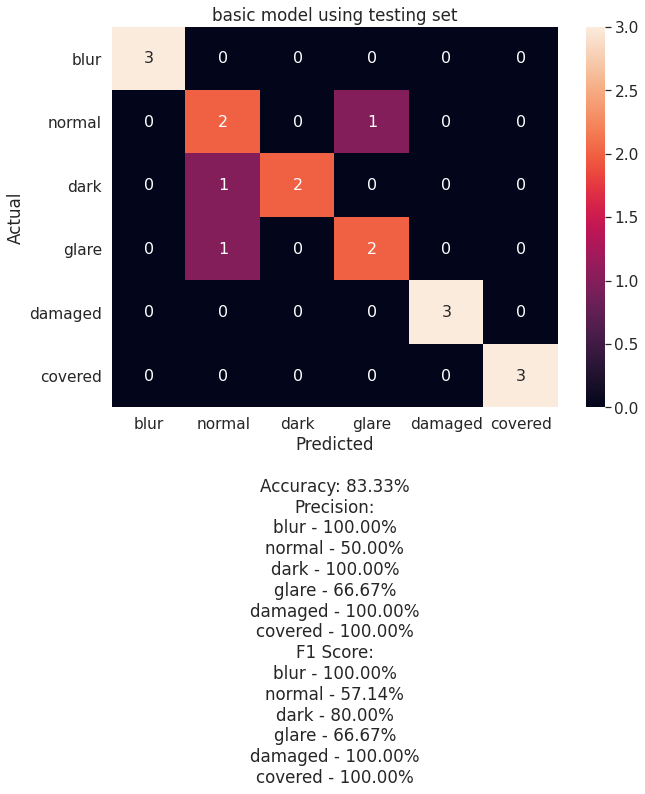

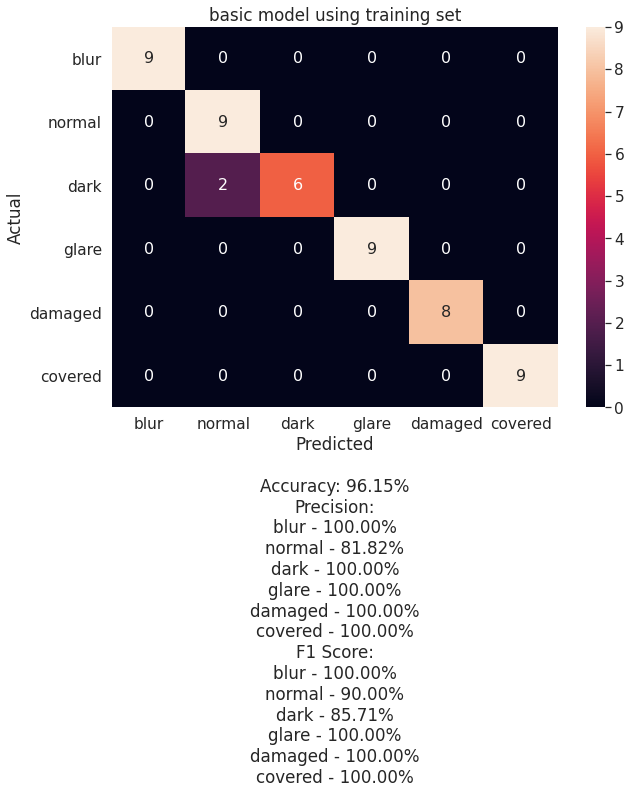

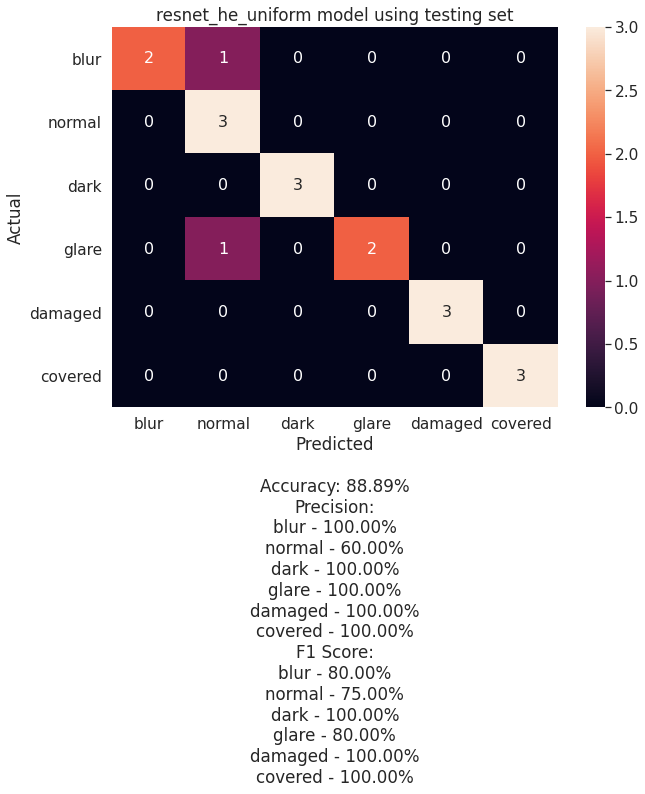

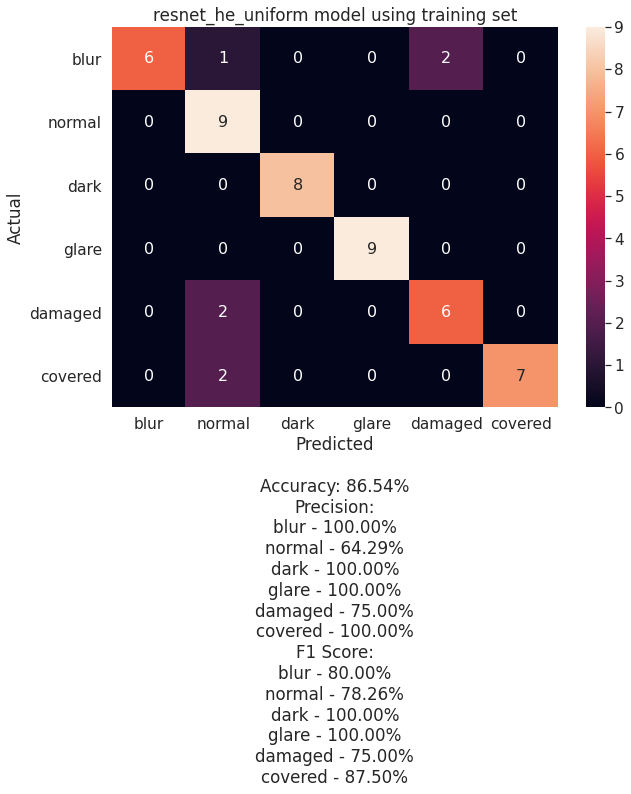

In [30]:
# models = ['basic', 'resnet_he_uniform', 'mobilenet']
models = ['basic', 'resnet_he_uniform']
accs = list(map(display_model_result, models))

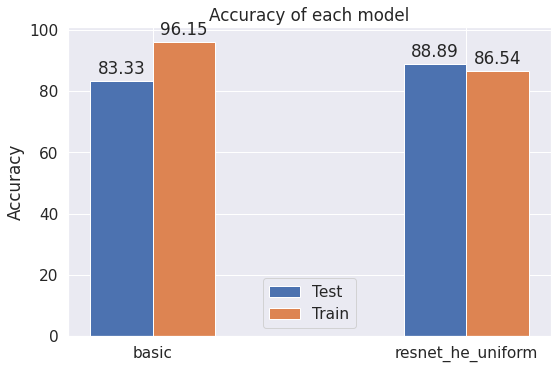

In [31]:
display_all_models(models, accs)